# Déploiement d'un modèle dans le cloud

---

Ce notebook est une première chaîne de traitement d'images qui comprend le preprocessing et une étape de réduction de dimension pour un outil de classification d'image

---

## Imports

In [1]:
# librairies classiques
import numpy as np
import pandas as pd
import os
import time
import logging
import matplotlib.pyplot as plt


# librairies pyspark
import pyspark
from typing import Iterator
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import *
from pyspark.sql.functions import udf, pandas_udf, PandasUDFType
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.linalg import VectorUDT, DenseVector
from pyspark.ml.image import ImageSchema

# librairie de connexion au service S3 d'AWS
import boto3

#librairies tensorflow
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#chemins du bucket s3
BUCKET = "s3a://imagesp8alexis/*"

## Fonctions

In [2]:
@udf(VectorUDT())
def get_features(image):
    '''
        Permet l'extraction des features d'une image à partir du modèle VGG16
        
        Input:
        ------
        image : spark image
            
        Output:
        -------
        DenseVector   
    ''' 
    array = ImageSchema.toNDArray(image)         #conversion de l'image en numpy array 
    preprocessed = preprocess_input(array)       #appel de la fonction vgg16
    reshaped = preprocessed.reshape(1,100,100,3) # reshape de l'array pour le modèle
    X_features = vgg16.predict(reshaped) 
    
    return DenseVector(X_features.flatten())

@udf(StringType())
def category(origin):
    '''
    Retourne la catégorie de l'image:
        Split les chemins images et sélectionne l'avant dernier élément 
        correspondant à la catégorie image
    
    Input:
    -----
    image.origin
    
    Output:
    ------
    colonne df spark contenant la catégorie pour chaque image
    '''
    return origin.split("/")[-2]

def load_data(BUCKET):
    '''
        Permet la lecture du répertoire S3 contenant les images et retourne
        un spark dataframe contenant les images
        
        
        Input:
        ------
        path : string
               Chemin d'accès S3 du répertoire contenant le images
               
        spark_session : SparkSession
                        La session Spark active

        Output:
        -------
        Dataframe Spark   
    ''' 
    #timer
    start = time.time()
    
    #lecture des images depuis le bucket S3
    df = spark.read.format("image").load(BUCKET)
    
    #ajout d'une colonne contenant le chemin des images
    df = df.withColumn("category", category("image.origin"))
           
    #affichages
    print('Chargement terminé.')
    print('Temps de chargement des images : {} secondes'.format(time.strftime('%S',
                                                    time.gmtime(time.time()-start))))
    print("nombre d'images chargées:", df.count())
    print("Structure du dataframe:")
    df.printSchema()
    print("Dataframe :")
    df.show()
    
    return df

def vgg16_init():
    '''
        Renvoie un modèle VGG 16        
        Taille d'entrée des images : 100x100x3
    '''
    #modèle vgg16 sans la couche supérieur
    vgg16 = VGG16(
        include_top=False,
        weights=None,
        pooling='max',
        input_shape=(100, 100, 3))
    
    return vgg16

def display_scree_plot(pca):
    '''affiche un scree plot pour la pca'''

    scree = pca.explainedVariance*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.show(block=False)
    
def scatter_plot_pca(X_pca, y):
    '''affiche un scatter plot 2d de la pca'''
    
    markers = 's', 'x', 'o', 'v'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    plt.figure(figsize=(10,5))
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], 
                    subset[:, 1], 
                    s = 10,
                    c = colors[idx]['color'], label = t, marker = m)
        
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper left')
    plt.tight_layout()
    plt.title("scatter plot 2d pca")
    plt.show()

## Chargement des données

In [3]:
#Initialisation session boto3
session = boto3.session.Session()
credentials = session.get_credentials()

#Récupération des clés d'accès et stockage dans une variable d'environnement
os.environ['AWS_ACCESS_KEY_ID'] = credentials.access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = credentials.secret_key

In [4]:
# Initialisation session spark
spark = SparkSession.builder.appName('P8').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/28 16:00:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#session spark actuelle
spark

adresse locale : "AdresseIP_attribuée_automatiquement":4040

ex : 13.37.250.245:4040

In [6]:
ImageSchema.imageFields

['origin', 'height', 'width', 'nChannels', 'mode', 'data']

In [7]:
#chargement des images 
df = load_data(BUCKET).repartition(8)

22/10/28 16:00:25 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties
Chargement terminé.
Temps de chargement des images : 05 secondes


nombre d'images chargées: 40
Structure du dataframe:
root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- category: string (nullable = true)

Dataframe :


+--------------------+----------------+
|               image|        category|
+--------------------+----------------+
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|         Apricot|
|{s3a://imagesp8al...|             Fig|
|{s3a://imagesp8al...|AppleGrannySmith|
|{s3a://imagesp8al...|AppleGrannySmith|
|{s3a://imagesp8al...|             Fig|
|{s3a://imagesp8al...|             Fig|
|{s3a://imagesp8al...|AppleGrannySmith|
|{s3a://imagesp8al...|AppleGrannySmith|
|{s3a://imagesp8al...|AppleGrannySmith|
|{s3a://imagesp8al...|             Fig|
|{s3a://imagesp8al...|AppleGrannySmith|
+--------------------+----------------+
only showing top 20 rows



## Extraction des features

In [8]:
#appel de fonction d'initilisation d'un modèle vgg16
vgg16 = vgg16_init() 
vgg16.summary()

2022-10-28 16:00:38.163098: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-28 16:00:38.163147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-47-168): /proc/driver/nvidia/version does not exist
2022-10-28 16:00:38.165439: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [9]:
# extraction des features de l'image à l'aide du VGG16
start = time.perf_counter()
featurized_df = df.withColumn('cnn_features', get_features('image')).cache()
stop = time.perf_counter()
print(f'Temps extraction des features: {stop - start:0.2f} secondes')

2022-10-28 16:00:39.231396: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://17cb1797-4738-4de9-a192-53718bdcc567/assets
Temps extraction des features: 2.63 secondes


In [10]:
featurized_df.show()

2022-10-28 16:00:45.776921: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-28 16:00:45.776971: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-31-47-168): /proc/driver/nvidia/version does not exist
2022-10-28 16:00:45.777301: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 16:00:51.512858: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-28 16:00:51.512904: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runn

+--------------------+----------------+--------------------+
|               image|        category|        cnn_features|
+--------------------+----------------+--------------------+
|{s3a://imagesp8al...|         Apricot|[0.44977459311485...|
|{s3a://imagesp8al...|             Fig|[0.36610150337219...|
|{s3a://imagesp8al...|         Apricot|[0.41223129630088...|
|{s3a://imagesp8al...|AppleGrannySmith|[0.47027322649955...|
|{s3a://imagesp8al...|          Banana|[0.33487695455551...|
|{s3a://imagesp8al...|          Banana|[0.40485137701034...|
|{s3a://imagesp8al...|         Apricot|[0.44093197584152...|
|{s3a://imagesp8al...|         Apricot|[0.42068630456924...|
|{s3a://imagesp8al...|             Fig|[0.37644225358963...|
|{s3a://imagesp8al...|             Fig|[0.39170134067535...|
|{s3a://imagesp8al...|          Banana|[0.37126508355140...|
|{s3a://imagesp8al...|AppleGrannySmith|[0.47091910243034...|
|{s3a://imagesp8al...|         Apricot|[0.43171134591102...|
|{s3a://imagesp8al...|  

In [11]:
#observation du nombre de features par images
@udf(VectorUDT())
def array_shape(array):
    return DenseVector(array.shape)
    
featurized_df.select(array_shape('cnn_features')).show()

+-------------------------+
|array_shape(cnn_features)|
+-------------------------+
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
|                  [512.0]|
+-------------------------+
only showing top 20 rows



Le VGG a permis de créer 512 features par images.

## Réduction de dimensions

In [12]:
# standard scaler
scaler = StandardScaler(inputCol="cnn_features", 
                        outputCol="scaled_features",
                        withMean=True,
                        withStd=True)

In [13]:
X_scaled = scaler.fit(featurized_df)
featurized_df = X_scaled.transform(featurized_df)

In [14]:
pca = PCA(k=10, 
          inputCol="scaled_features", 
          outputCol="PCA_scaled_features")

La valeur de K est a ajustée en fonction des résultats du scree plot ci-dessous.
Ici pour k=10, on conserve plus de 90% de la variance des données lors de la réduction de dimension.

In [15]:
PCA_X_scaled = pca.fit(featurized_df)
featurized_df = PCA_X_scaled.transform(featurized_df)

22/10/28 16:01:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/28 16:01:03 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/28 16:01:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/10/28 16:01:04 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


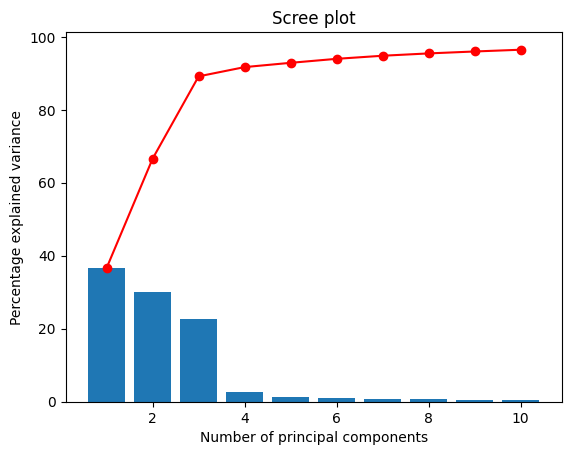

In [16]:
display_scree_plot(PCA_X_scaled)

In [17]:
featurized_df.show()

+--------------------+----------------+--------------------+--------------------+--------------------+
|               image|        category|        cnn_features|     scaled_features| PCA_scaled_features|
+--------------------+----------------+--------------------+--------------------+--------------------+
|{s3a://imagesp8al...|         Apricot|[0.44977459311485...|[0.83426054602665...|[-5.5212656335726...|
|{s3a://imagesp8al...|             Fig|[0.36610150337219...|[-1.0841324337059...|[5.53230211827247...|
|{s3a://imagesp8al...|         Apricot|[0.41223129630088...|[-0.0265036168055...|[-5.4028525715773...|
|{s3a://imagesp8al...|AppleGrannySmith|[0.47027322649955...|[1.30423762587721...|[-17.922889622188...|
|{s3a://imagesp8al...|          Banana|[0.33487695455551...|[-1.8000251469960...|[13.4763781936275...|
|{s3a://imagesp8al...|          Banana|[0.40485137701034...|[-0.1957047948845...|[19.5067715378893...|
|{s3a://imagesp8al...|         Apricot|[0.44093197584152...|[0.6315237407

In [18]:
#conversion spark dataframe vers pandas dataframe
df_p = featurized_df.toPandas()
df_p.head()

,image,category,cnn_features,scaled_features,PCA_scaled_features
0,"(s3a://imagesp8alexis/Apricot/16_100.jpg, 100,...",Apricot,"[0.4497745931148529, 0.5291685461997986, 0.0, ...","[0.8342605460266573, -1.2842584635627383, 0.0,...","[-5.521265633572694, 0.34565780126915796, -17...."
1,"(s3a://imagesp8alexis/Fig/8_100.jpg, 100, 100,...",Fig,"[0.3661015033721924, 0.8919914960861206, 0.0, ...","[-1.0841324337059426, 1.2792985714208918, 0.0,...","[5.532302118272479, -19.727777515510677, 4.757..."
2,"(s3a://imagesp8alexis/Apricot/1_100.jpg, 100, ...",Apricot,"[0.41223129630088806, 0.5415899157524109, 0.0,...","[-0.02650361680557513, -1.1964941991723308, 0....","[-5.402852571577385, 0.4032236877955227, -16.6..."
3,(s3a://imagesp8alexis/AppleGrannySmith/15_100....,AppleGrannySmith,"[0.4702732264995575, 0.6410220861434937, 0.0, ...","[1.304237625877219, -0.4939475714311272, 0.0, ...","[-17.92288962218855, 6.296690734214174, 9.4182..."
4,"(s3a://imagesp8alexis/Banana/56_100.jpg, 100, ...",Banana,"[0.3348769545555115, 0.7257764935493469, 0.0, ...","[-1.8000251469960333, 0.10489204833167634, 0.0...","[13.476378193627522, 12.251172134368183, 3.177..."


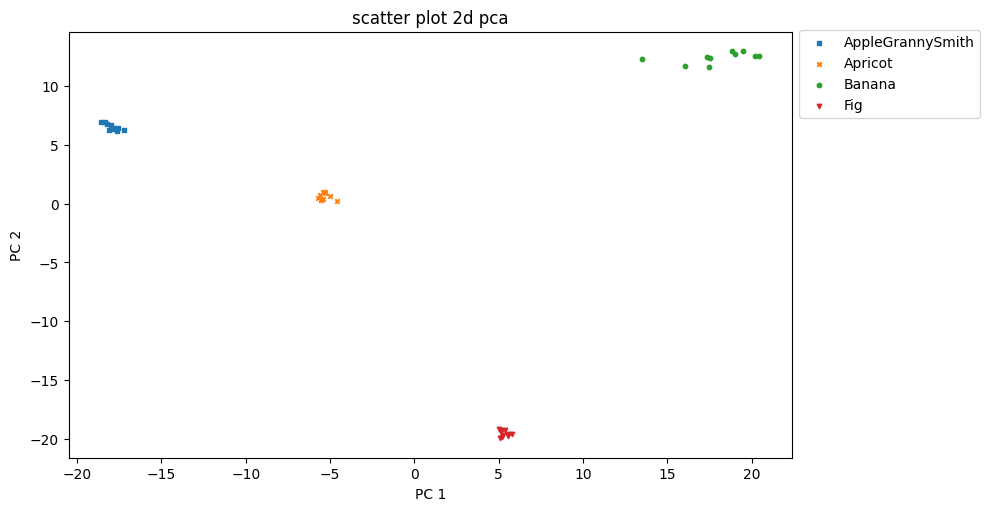

In [19]:
#conversion des lignes des valeurs de PCA_scaled_features en numpy array
X_pca = featurized_df.rdd.map(lambda row: row.PCA_scaled_features).collect()
X_pca = np.array(X_pca)

#affichage du scatter plot résultant de la PCA
scatter_plot_pca(X_pca, df_p['category'])

La visualisation 2d des deux premières composantes de la PCA permet de voir l'efficacité du VGG16 pour distinguer les échantillons de fruits.

## Enregistrement des données dans le bucket AWS S3

In [20]:
#enregistrement au format parquet
featurized_df.select('PCA_scaled_features', 'category')\
    .write.mode("overwrite") \
    .parquet("s3a://p8alexis/results.parquet")

In [21]:
#lecture depuis le S3 pour vérification
spark.read.parquet("s3a://p8alexis/results.parquet").show(20)

+--------------------+----------------+
| PCA_scaled_features|        category|
+--------------------+----------------+
|[-5.5212656335726...|         Apricot|
|[5.53230211827247...|             Fig|
|[-5.4028525715773...|         Apricot|
|[-17.922889622188...|AppleGrannySmith|
|[13.4763781936275...|          Banana|
|[19.5067715378893...|          Banana|
|[-5.7344205745214...|         Apricot|
|[-4.5866631935415...|         Apricot|
|[4.99776300903587...|             Fig|
|[5.79973474616922...|             Fig|
|[17.4707842400330...|          Banana|
|[-18.010996583884...|AppleGrannySmith|
|[-5.3150017373686...|         Apricot|
|[5.06795575099437...|             Fig|
|[-17.664605788090...|AppleGrannySmith|
|[17.3547681797583...|          Banana|
|[-18.351040242097...|AppleGrannySmith|
|[5.11554441346874...|             Fig|
|[-18.239995997318...|AppleGrannySmith|
|[-17.550651879040...|AppleGrannySmith|
+--------------------+----------------+
only showing top 20 rows



In [22]:
# stop la sparkSession
#spark.stop()